In [1]:
from utils import *
from matplotlib import pyplot as plt

Video loaded
920 720
30.00030000300003


<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
C:\Users\krzysztof\AppData\Local\Temp\ipykernel_16336\2804618588.py:1: SyntaxWarning: invalid escape sequence '\E'
  chess = video_from_path('recordings\Easy2.mp4')


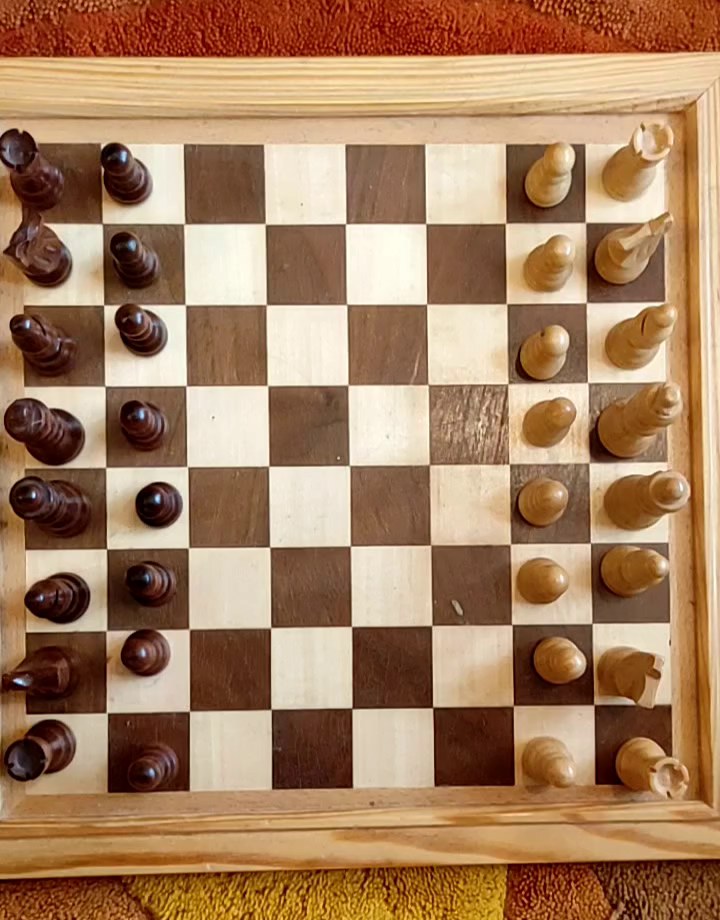

In [75]:
chess = video_from_path('recordings\Easy2.mp4')
frame = get_first_frame(chess)
contours = load_contour_parameters('Easy2')[0]

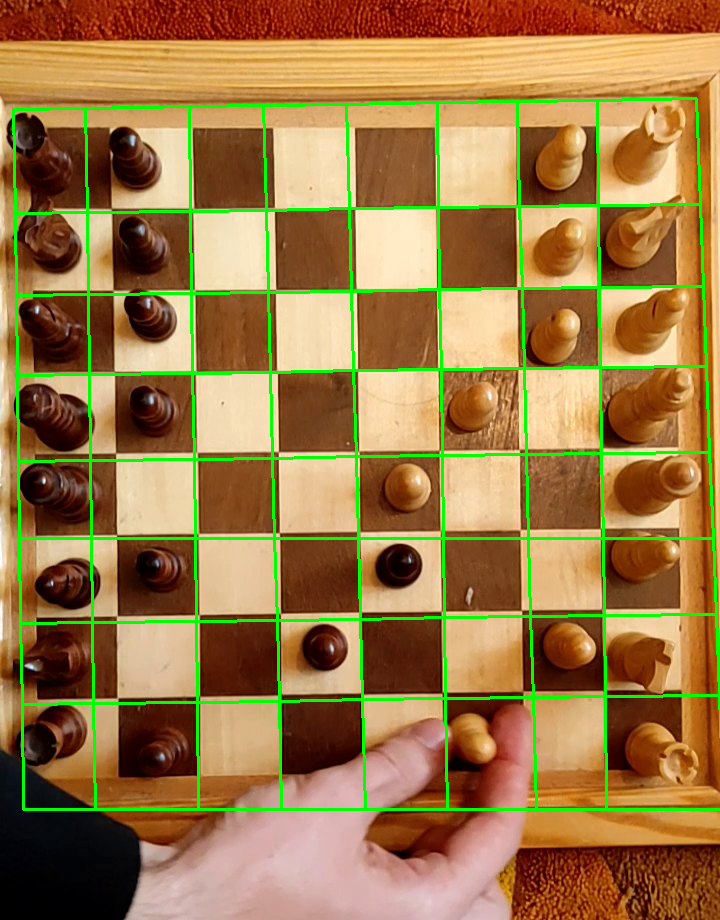

True

In [119]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 1000)
_, frame_copy = chess.read()
cv2.drawContours(frame_copy, contours[0], -1, (0, 255, 0), 2)
imshow(frame_copy)
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)

### Sobel analyses

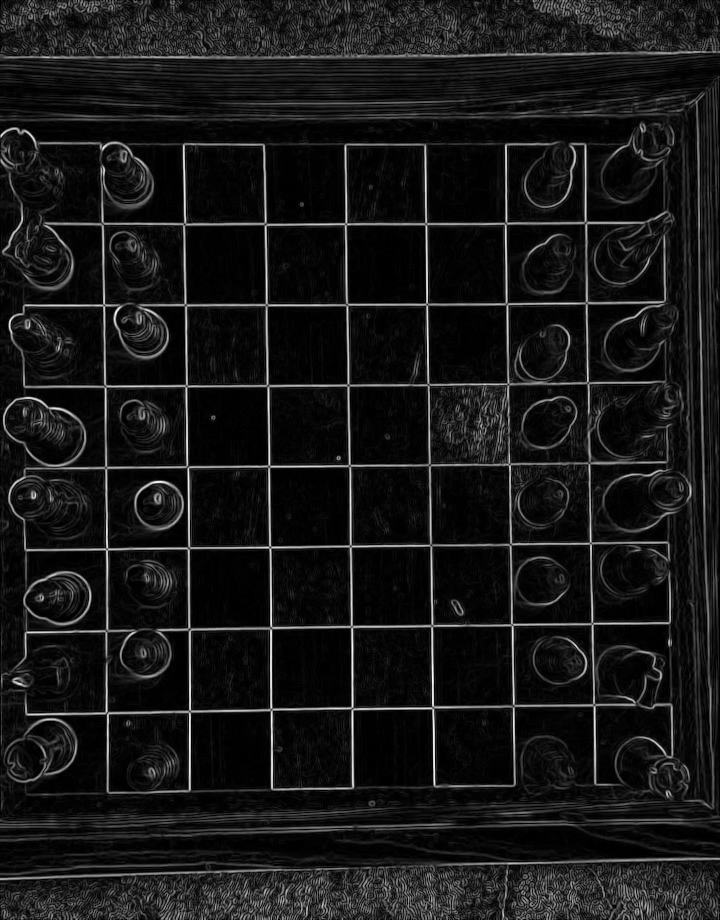

In [77]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

sobel_x = cv2.Sobel(gray_frame, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_frame, cv2.CV_64F, 0, 1, ksize=3)

sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_combined = np.uint8(sobel_combined / np.max(sobel_combined) * 255)

imshow(sobel_combined)

In [78]:
def average_brightness(contour, image):
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [contour], -1, 255, -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    nonzero_pixels = cv2.countNonZero(masked_image)
    if nonzero_pixels > 0:
        total_brightness = np.sum(masked_image) / nonzero_pixels
        return total_brightness
    return 0  # Return 0 if no pixels in the contour region

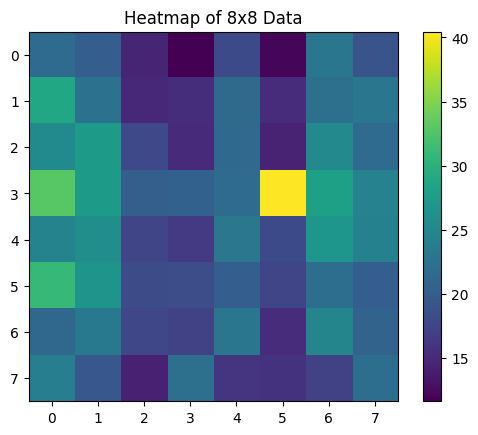

In [79]:
brightness = np.zeros(64)
for i, contour in enumerate(contours):
    brightness[i] = average_brightness(contour, sobel_combined)

brightness = brightness.reshape((8,8))

plt.imshow(brightness, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()

### Circle finding

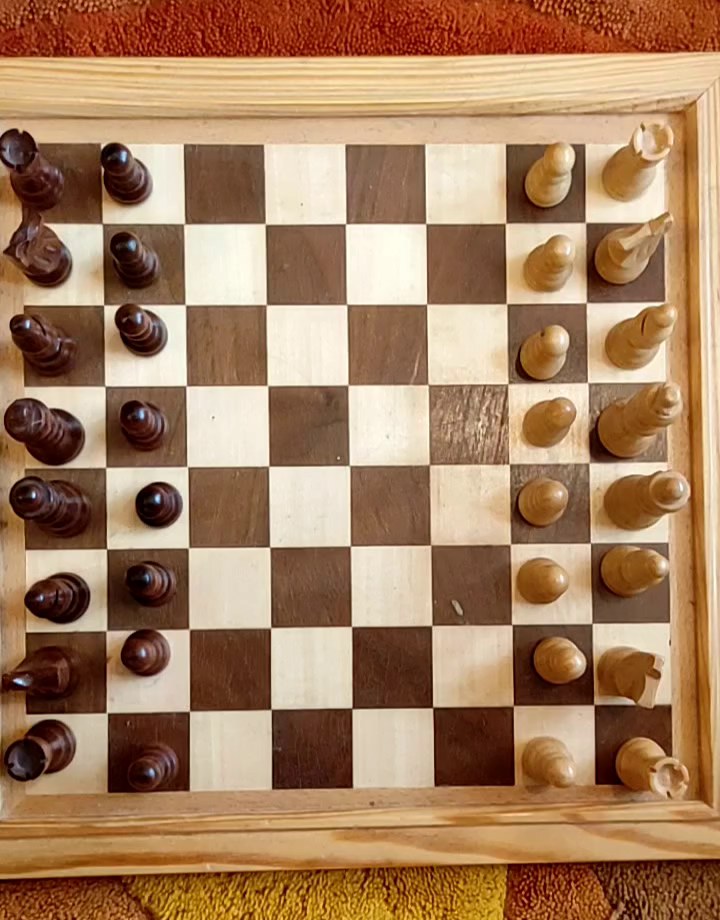

In [80]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, frame = chess.read()
imshow(frame)

[(158, 504), (540, 580), (144, 652), (48, 746), (540, 414), (546, 184), (66, 596), (54, 436), (542, 500), (616, 248), (556, 660), (634, 498), (126, 178), (16, 148), (48, 266), (144, 334), (628, 346), (644, 762), (32, 498), (644, 190), (624, 680), (546, 270), (634, 420), (540, 352), (136, 266), (138, 434), (626, 570), (144, 586), (654, 138), (146, 768), (542, 764), (256, 892)]


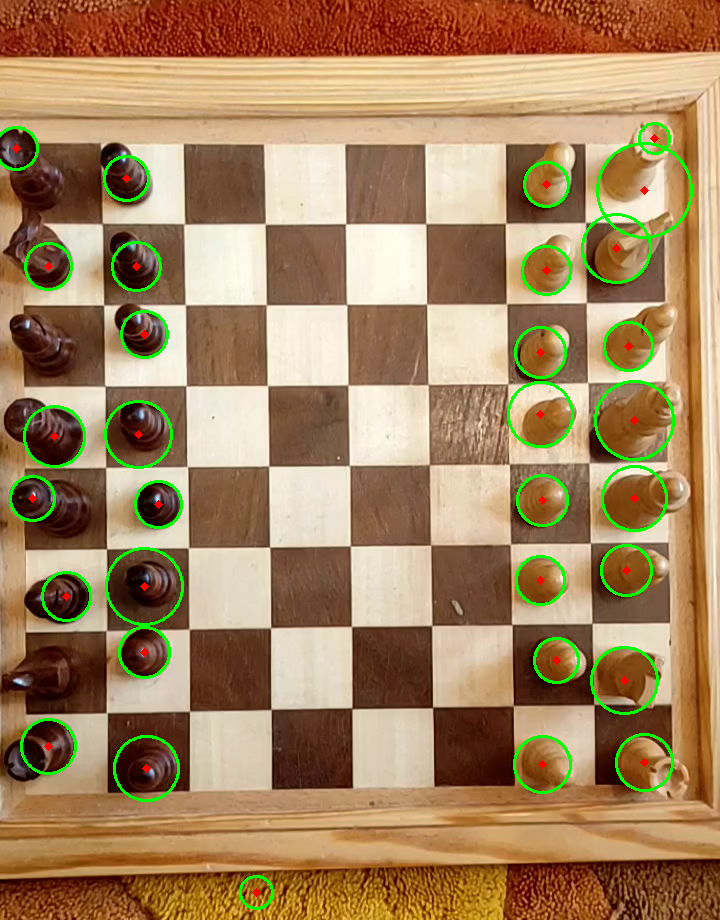

In [81]:
def find_circles(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_frame, (9, 9), 2)

    circles = cv2.HoughCircles(
        blurred_image, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=100, param2=20, minRadius=10, maxRadius=50
    )

    image = frame.copy()

    if circles is not None:
        circles = np.uint16(np.around(circles))
        centers = list()

        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            # Draw the outer circle
            cv2.circle(image, center, radius, (0, 255, 0), 2)
            # Draw the center of the circle
            cv2.circle(image, center, 2, (0, 0, 255), 3)

            centers.append(center)

    return image, centers

image, centers = find_circles(frame)
print(centers)
imshow(image)

### Other edge analyses 

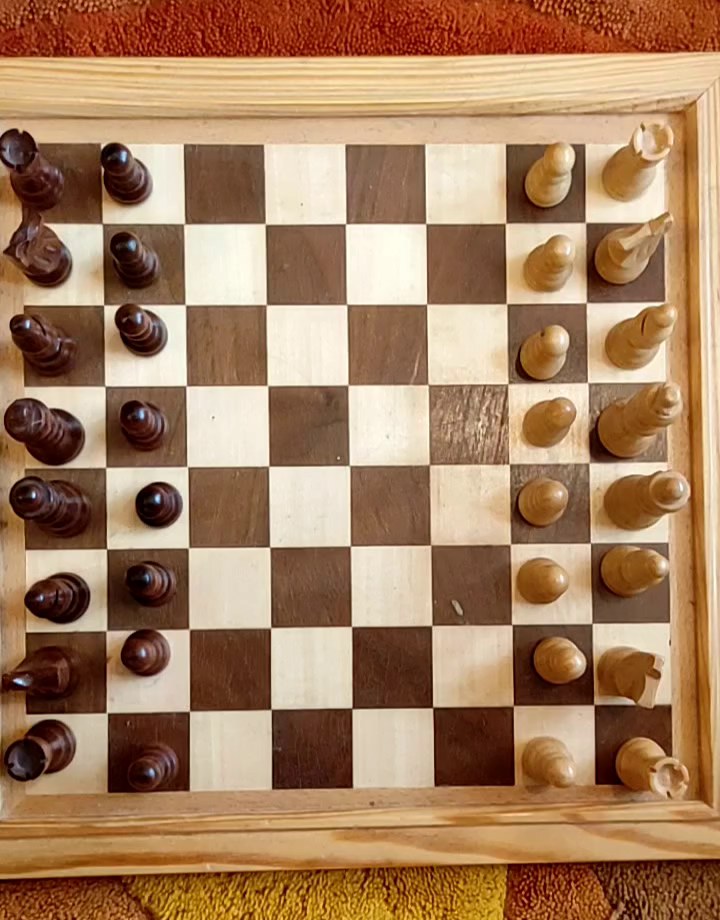

In [84]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, frame = chess.read()
imshow(frame)

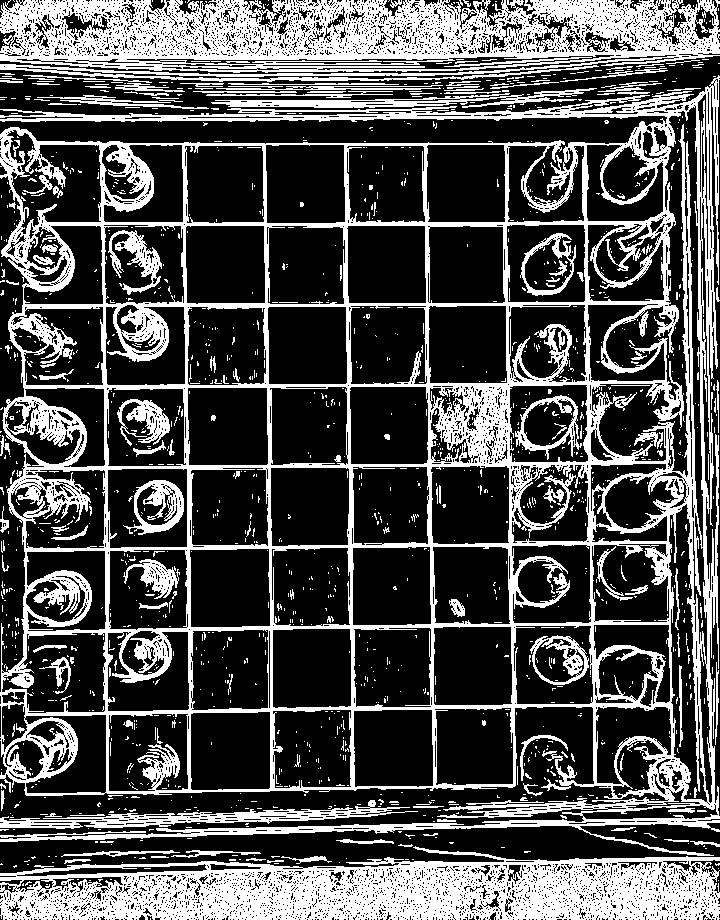

In [85]:
gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

sobel_x = cv2.Sobel(gray_frame, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_frame, cv2.CV_64F, 0, 1, ksize=3)

sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_combined = np.uint8(sobel_combined / np.max(sobel_combined) * 255)

sobel_threshold = 255 * (sobel_combined > 20).astype(np.uint32)

imshow(sobel_threshold)

In [86]:
def average_contour_distance(image, contours):
    distances = [list() for _ in range(64)]
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > 0:
                for k , contour in enumerate(contours):
                    distance = cv2.pointPolygonTest(contour, (j, i), measureDist=True)
                    if distance > 5:
                        distances[k].append(distance * image[i][j])

    return distances

distances = average_contour_distance(sobel_threshold, contours)


In [87]:
distances_average = np.array([np.average(d) for d in distances])
distances_average = distances_average.reshape((8,8))
distances_average.shape

c:\Python312\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(8, 8)

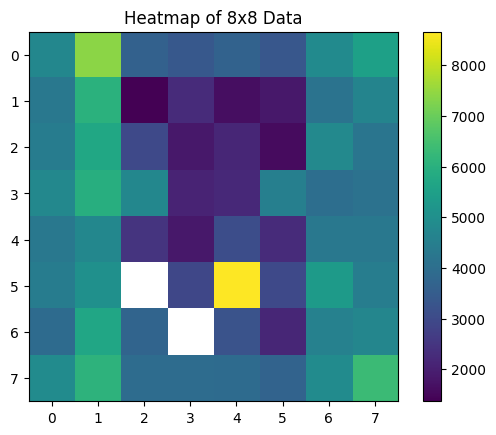

In [88]:
plt.imshow(distances_average, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()

### background

In [89]:
width = int(chess.get(3))
height = int(chess.get(4))

fps = chess.get(cv2.CAP_PROP_FPS)

background_writer = cv2.VideoWriter(
    "test/test1.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
    0,
)

foreground_mog2 = cv2.createBackgroundSubtractorMOG2()


chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
while chess.isOpened():
    ret, frame = chess.read()

    if ret:
        background_writer.write(foreground_mog2.apply(frame))
    else:
        break

background_writer.release()

In [90]:
foreground_video = video_from_path('test/test1.mp4')

Video loaded
920 720
30.0


In [91]:
width = int(foreground_video.get(3))
height = int(foreground_video.get(4))

fps = foreground_video.get(cv2.CAP_PROP_FPS)

average_foregrounds = list()

foreground_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
while foreground_video.isOpened():
    ret, frame = foreground_video.read()

    if ret:
        average_foregrounds.append(np.average(frame))
    else: 
        break

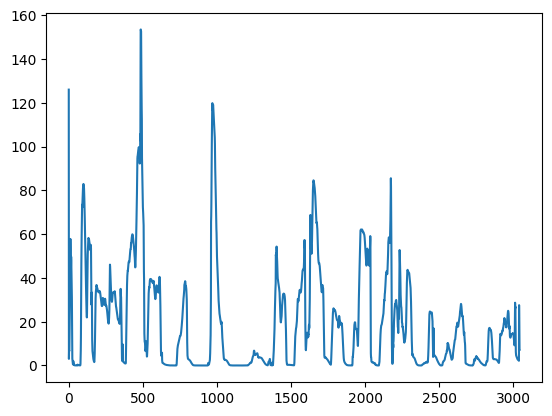

In [92]:
plt.plot(average_foregrounds)

In [93]:
width = int(chess.get(3))
height = int(chess.get(4))

fps = chess.get(cv2.CAP_PROP_FPS)

test_writer = cv2.VideoWriter(
    "test/test2.mp4",
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
    1,
)

i = 0
used_frames = np.zeros(len(average_foregrounds), np.bool_)

chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
while chess.isOpened():
    ret, frame = chess.read()
    if ret:
        if average_foregrounds[i] < 10:
            test_writer.write(frame)
            used_frames[i] = True
        i += 1
    else:
        break

test_writer.release()

### circle on the video

In [94]:
hand_cut = video_from_path('test/test2.mp4')

width = int(hand_cut.get(3))
height = int(hand_cut.get(4))

fps = hand_cut.get(cv2.CAP_PROP_FPS)


test_writer3 = cv2.VideoWriter(
    'test/test3_circles.mp4',
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (width, height),
    True
)

centers_frame = list()

hand_cut.set(cv2.CAP_PROP_POS_FRAMES, 0)
while hand_cut.isOpened():
    ret, frame = hand_cut.read()

    if ret:
        image, centers = find_circles(frame)
        centers_frame.append(centers)
        test_writer3.write(image)
    else:
        break

test_writer3.release()

Video loaded
920 720
30.0


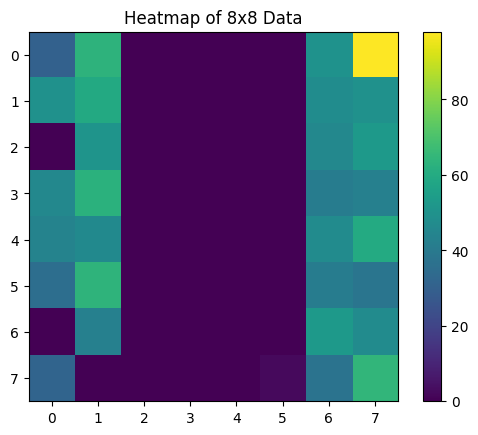

In [95]:
contours_frame = load_contour_parameters('Easy2')

circles_count = np.zeros(64)

j = 0
for i, contour in enumerate(contours):
    for center in centers_frame[j]:
        distance = cv2.pointPolygonTest(contour, center, measureDist=True)
        bias = 20
        if distance > -bias:
            circles_count[i] += distance + bias


plt.imshow(circles_count.reshape((8, 8)), cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()



In [96]:
contours_frame = load_contour_parameters('Easy2')

n = np.sum(used_frames)
circles_count = np.zeros((n, 64))

j = 0
for k, contours in enumerate(contours_frame):
    if used_frames[k]:
        for i, contour in enumerate(contours):
            for center in centers_frame[j]:
                distance = cv2.pointPolygonTest(contour, center, measureDist=True)
                bias = 20
                if distance > -bias:
                    circles_count[j][i] += distance + bias
        j += 1


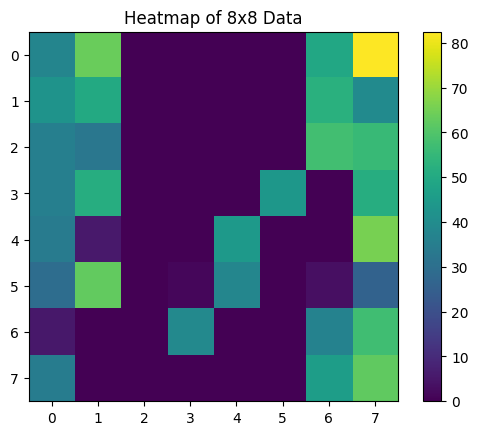

In [97]:
plt.imshow(circles_count[300].reshape((8,8)), cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()

In [98]:
import chess as ch

In [99]:
chessboard = np.array((
    ['h8', 'h7', 'h6', 'h5', 'h4', 'h3', 'h2', 'h1'],
    ['g8', 'g7', 'g6', 'g5', 'g4', 'g3', 'g2', 'g1'],
    ['f8', 'f7', 'f6', 'f5', 'f4', 'f3', 'f2', 'f1'],
    ['e8', 'e7', 'e6', 'e5', 'e4', 'e3', 'e2', 'e1'],
    ['d8', 'd7', 'd6', 'd5', 'd4', 'd3', 'd2', 'd1'],
    ['c8', 'c7', 'c6', 'c5', 'c4', 'c3', 'c2', 'c1'],
    ['b8', 'b7', 'b6', 'b5', 'b4', 'b3', 'b2', 'b1'],
    ['a8', 'a7', 'a6', 'a5', 'a4', 'a3', 'a2', 'a1'],
))

chessboard = chessboard.reshape(64)


In [100]:
board = ch.Board()

for i in range(0, circles_count.shape[0]-3, 3):
    zeros1 = np.median(circles_count[i:i+3], axis=0) == 0
    zeros2 = np.median(circles_count[i+3:i+6], axis=0) == 0

    piece_positions = np.array([bool(board.piece_at(square)) for square in ch.SQUARES])
    piece_positions = piece_positions.reshape((8,8)).T
    piece_positions = np.rot90(piece_positions, k=2)
    piece_positions = piece_positions.reshape(64)

    undetected_figures = piece_positions & zeros1 & zeros2

    common = zeros1 & zeros2
    zeros1[common] = False
    zeros2[common] = False 

    zeros2[undetected_figures] = True

    if np.sum(zeros1) > 0 and np.sum(zeros2) > 0:
        start_positions = chessboard[zeros2]
        end_positions = chessboard[zeros1]

        possible_moves = list()
        for position1 in start_positions:
            for position2 in end_positions:
                move = position1 + position2
                if ch.Move.from_uci(move) in board.legal_moves:
                    possible_moves.append(move)

        if len(possible_moves) > 0:
            move = possible_moves[-1]
            print(move)
            print(possible_moves)
            board.push(ch.Move.from_uci(move))
            print(board)
                    
                    
        
    

d2d4
['d2d4']
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R
d7d5
['d7d5']
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . P . . . .
. . . . . . . .
P P P . P P P P
R N B Q K B N R
e2e3
['e2e3']
r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . P . . . .
. . . . P . . .
P P P . . P P P
R N B Q K B N R
b7b5
['b7b5']
r n b q k b n r
p . p . p p p p
. . . . . . . .
. p . p . . . .
. . . P . . . .
. . . . P . . .
P P P . . P P P
R N B Q K B N R
a2a4
['a2a4']
r n b q k b n r
p . p . p p p p
. . . . . . . .
. p . p . . . .
P . . P . . . .
. . . . P . . .
. P P . . P P P
R N B Q K B N R
b8a6
['b8a6']
r . b q k b n r
p . p . p p p p
n . . . . . . .
. p . p . . . .
P . . P . . . .
. . . . P . . .
. P P . . P P P
R N B Q K B N R
b1c3
['c2c3', 'b1c3']
r . b q k b n r
p . p . p p p p
n . . . . . . .
. p . p . . . .
P . . P . . . .
. . N . P . . .
. P P . . P P P
R . B Q K B N 

### Histogram

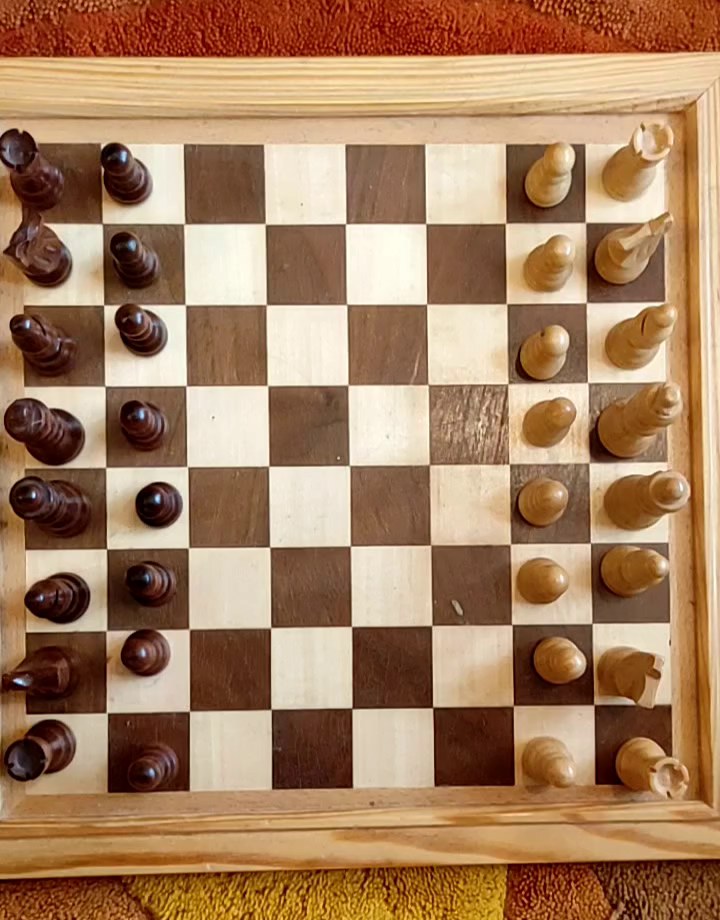

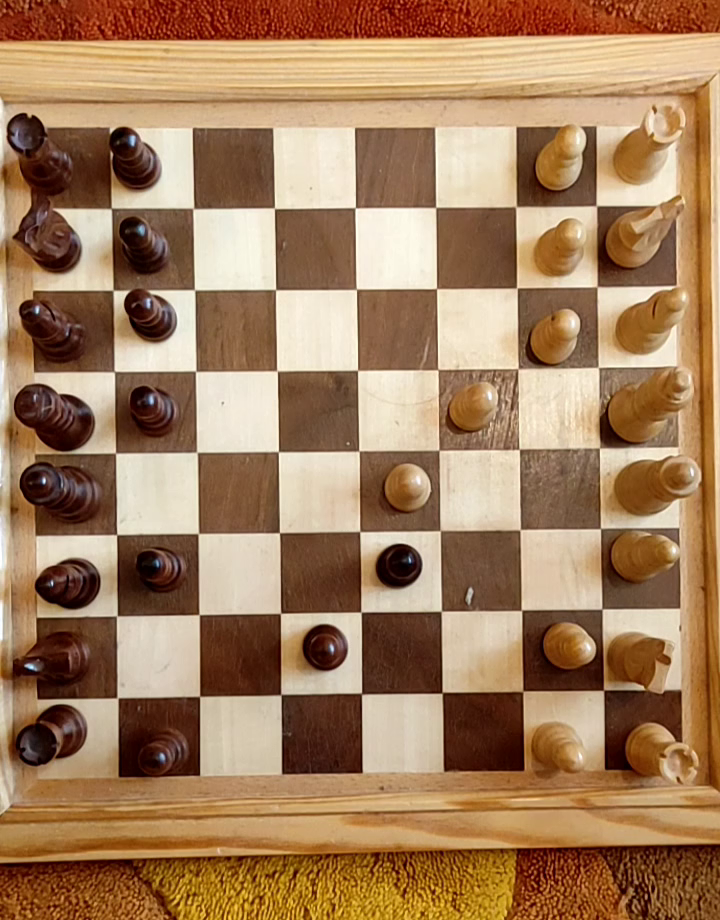

In [160]:
chess.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, frame1 = chess.read()
chess.set(cv2.CAP_PROP_POS_FRAMES, 900)
_, frame2 = chess.read()
contours = load_contour_parameters('Easy2')[0]
imshow(frame1)
imshow(frame2)

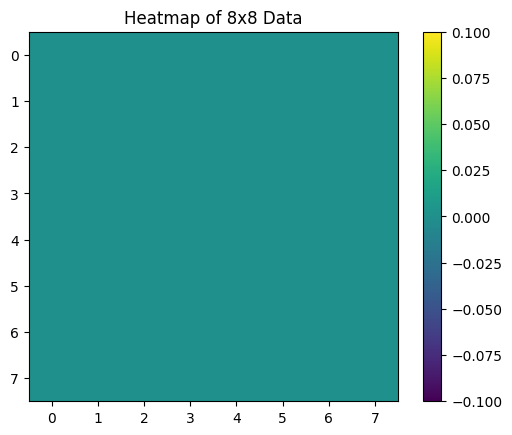

In [168]:
def calculate_histagram(gray_image, contour):
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    masked_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

    histogram = cv2.calcHist([masked_image], [0], mask, [256], [0, 256])

    kernel_size = 10
    smoothed_histogram = np.convolve(histogram.flatten(), np.ones(kernel_size) / kernel_size, mode='valid')

    return histogram



gray_image1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

sds1 = np.zeros(64)
sds2 = np.zeros(64)

for i, contour in enumerate(contours):
    histogram1 = calculate_histagram(gray_image1, contour)
    histogram2 = calculate_histagram(gray_image2, contour)
    sds1[i] = np.average(histogram1)
    sds2[i] = np.average(histogram2)

diff = sds1 - sds2
plt.imshow(diff.reshape((8,8)), cmap='viridis', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title('Heatmap of 8x8 Data')
plt.show()

